In [350]:
%reset -f

In [351]:
import gc
import sys
import numpy as np
from itertools import islice
from collections import Counter
import torch
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
gc.collect()

0

In [352]:
def db(expr):
    frame = sys._getframe(1)
    print(expr + ' : ' + str(eval(expr, frame.f_globals, frame.f_locals)))

In [353]:
with open('./dataset/corpus', 'rt') as fp:
    corpus = fp.read()

corpus = corpus.strip()
corpus = corpus.split()[:10000]
corpus_size = len(corpus)
print(corpus_size)

10000


In [354]:
class SkipGramBatcher:
    def __init__(self, corpus, window_size=4, batch_size=32):
        '''corpus - list of words'''
        self.corpus = corpus
        self.window_size = window_size
        self.batch_size = batch_size
        self.make_vocab()
        return
    
    def make_vocab(self):
        self.vocab = sorted(set(corpus))
        self.V = len(self.vocab)
        self.word2index = {w: idx for idx, w in enumerate(self.vocab)}
        self.index2word = {idx: w for idx, w in enumerate(self.vocab)}
        return
    
    def batch_gen(self):
        '''c - corpus, v - vocab ; i - central, j - side'''
        x_batch = np.empty(self.batch_size, dtype=np.int)
        y_batch = np.empty(self.batch_size, dtype=np.int)
        curr_idx = 0
        for c_i, w in enumerate(self.corpus):
            v_i = self.word2index[w]
            window_left_border = c_i - self.window_size
            if window_left_border < 0:
                window_left_border = 0
            for side_w in self.corpus[window_left_border: c_i] \
                          + self.corpus[c_i + 1 : c_i + self.window_size + 1]:
                v_j = self.word2index[side_w]
                x_batch[curr_idx] = v_i
                y_batch[curr_idx] = v_j
                curr_idx += 1
                if curr_idx == self.batch_size:
                    curr_idx = 0
                    yield (x_batch, y_batch)
        # drop last
        #if curr_idx != 0:
            #yield (x_batch, y_batch)

In [355]:
def freq_filter(corpus, threshold):
    freq_map = Counter(corpus)
    filtrator = lambda w: 'UNK' if freq_map[w] <= threshold else w
    corpus = map(filtrator, corpus)
    return list(corpus)

In [356]:
#corpus = freq_filter(corpus, 1)
#corpus.count('UNK') / len(corpus)

In [357]:
def w2v_forward(x, y, w_1, w_2, k=20):
    '''x - (batch_size x V) ohe batch to forward through
       y - targets (dim as of x)
       w - (V x N) weight matrix'''
    V, N = w_1.shape
    b = x.shape[0]
    
    h = x.mm(w_1)
    
    pos_ids = y
    
    central_batch = h.view(b, 1, N)
    pos_batch = w_2[:, pos_ids].view(b, N, 1)
    pos_scores = central_batch.bmm(pos_batch).squeeze()
    pos_scores = torch.nn.functional.logsigmoid(pos_scores)
    
    neg_corp_ids = np.random.randint(0, corpus_size, size=k)
    neg_ids = [batcher.word2index[corpus[i]] for i in neg_corp_ids]
    while not set(neg_ids).isdisjoint(pos_ids):
        print('unlucky gen!')
        neg_corp_ids = np.randint(0, corpus_size, size=k)
        neg_ids = [batcher.word2index[corpus[i]] for i in neg_corp_ids]
    
    neg_scores = h.mm(w_2[:, neg_ids])
    neg_scores = torch.nn.functional.logsigmoid(-1 * neg_scores)
    
    loss = -(pos_scores.sum() + neg_scores.sum())
    return loss

def random_weight(shape):
    """
    Create random Tensors for weights; setting requires_grad=True means that we
    want to compute gradients for these Tensors during the backward pass.
    We use Kaiming normalization: sqrt(2 / fan_in)
    """
    if len(shape) == 2:  # FC weight
        fan_in = shape[0]
    else:
        fan_in = np.prod(shape[1:]) # conv weight [out_channel, in_channel, kH, kW]
    # randn is standard normal distribution generator. 
    w = torch.randn(shape, dtype=torch.float32) * np.sqrt(2. / fan_in)
    w.requires_grad = True
    return w

In [358]:
batcher = SkipGramBatcher(corpus, batch_size=16)

In [359]:
V = batcher.V
N = 300
learning_rate = 0.1
print_every = 1
print(V)
print(N)

2520
300


In [360]:
def train(w_1, w_2, optimizer, epochs=1):
    """    
    Inputs:
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for
    """
    loss_values = []
    for e in range(epochs):
        
        loader_train = batcher.batch_gen()
        batch_size = batcher.batch_size
        epoch_loss = 0
        
        for t, (x_ids, y_ids) in enumerate(loader_train):
            
            input_buff = np.zeros((batch_size, V), dtype=np.float32)
            input_buff[np.arange(batch_size), x_ids] = 1

            x = torch.from_numpy(input_buff)
            y = torch.from_numpy(y_ids)

            loss = w2v_forward(x, y, w_1, w_2)
            #print(type(loss))
            #print(loss)

            epoch_loss += loss.item()
            
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            if t % print_every == 0:
                #print('e: %d | batch: %d, loss = %.9f' % (e, t, loss.item())) # batch loss
                pass
        loss_values.append(epoch_loss)
        print('e: %d | loss = %.9f' % (e, epoch_loss))
    return loss_values

In [361]:
w_1 = random_weight((V, N))
w_2 = random_weight((N, V))
optimizer = torch.optim.SGD([w_1, w_2], lr=learning_rate)

loss_values = train(w_1, w_2, optimizer, epochs=16)

e: 0 | loss = 212497.394850413
e: 1 | loss = 762.327580353
e: 2 | loss = 248.451248485
e: 3 | loss = 169.950151584
e: 4 | loss = 132.383738679
e: 5 | loss = 108.105886179
e: 6 | loss = 90.907237545
e: 7 | loss = 79.524973627
e: 8 | loss = 69.691977457
e: 9 | loss = 62.309015244
e: 10 | loss = 55.936456238
e: 11 | loss = 51.121390616
e: 12 | loss = 47.154464226
e: 13 | loss = 43.426074421
e: 14 | loss = 40.093094168
e: 15 | loss = 37.721082776


It took five minutes to train.

In [377]:
def plot_metric(x, y):
    plt.figure(figsize=(16, 8))
    plt.plot(x, y, 'o-', label='train')
    plt.xlabel('epochs')
    plt.ylabel('ns_loss')
    plt.legend(loc='best')
    plt.grid()
    plt.show()

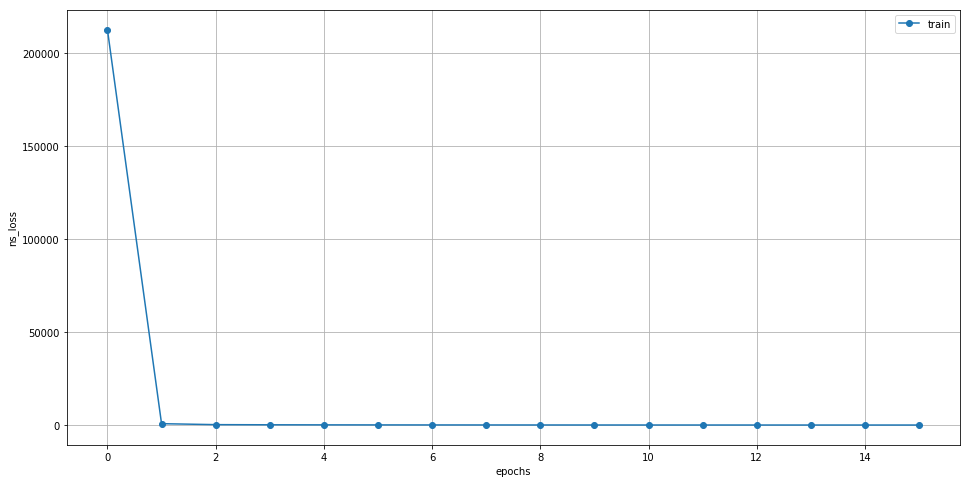

In [378]:
plot_metric(range(len(loss_values)), loss_values)

In [364]:
W = w_1.data.numpy()

In [365]:
def get_word_vector(token):
    '''function to map token to corresponding word vector'''
    idx = batcher.word2index[token]
    return W[idx]

### Plot vector progections of 50 most frequent words (beautiful visualization)

In [366]:
def reduce_to_k_dim(M, k=2):
    n_iter = 10
    M_reduced = None
    print("Running Truncated SVD over %i words..." % (M.shape[0]))
    
    svd = TruncatedSVD(n_components=k, n_iter=n_iter)
    M_reduced = svd.fit_transform(M)
    
    print("Done.")
    return M_reduced

In [367]:
W_reduced = reduce_to_k_dim(W)

Running Truncated SVD over 2520 words...
Done.


In [368]:
def plot_embeddings(M_reduced, word2Ind, words):
    plt.figure(figsize=(10, 16))
    for w in words:
        idx = word2Ind[w]
        x, y = M_reduced[idx]
        plt.scatter(x, y, marker='x', color='red')
        plt.text(x, y, w, fontsize=11)
    ax = plt.gca()
    ax.spines['left'].set_position(('data', 0))
    ax.spines['bottom'].set_position(('data', 0))
    plt.grid()
    plt.show()

In [369]:
freq_map = Counter(corpus)
most_freq_words = sorted(freq_map.items(), key=lambda x: x[-1], reverse=True)
most_freq_words = list(zip(*most_freq_words))[0]

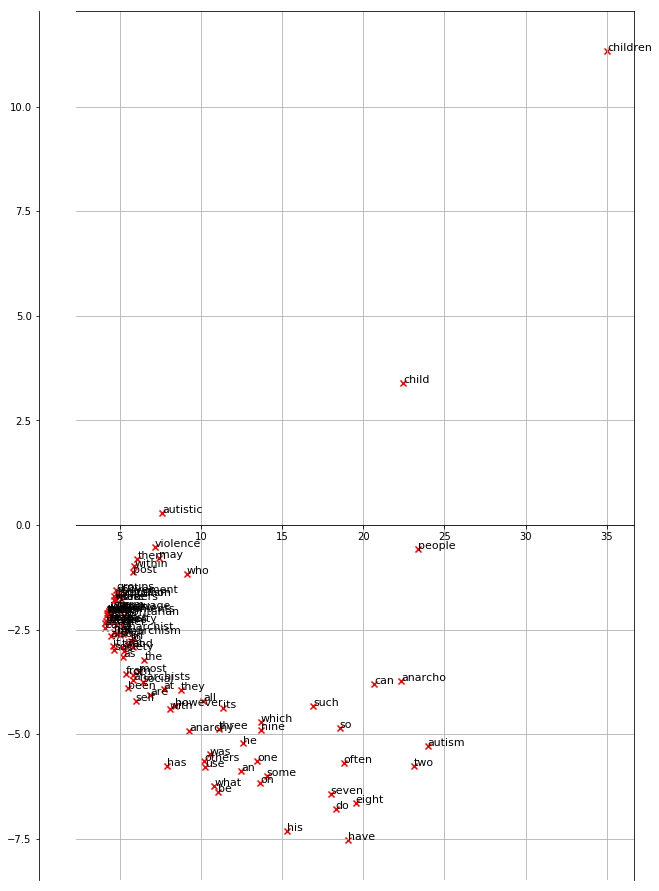

In [370]:
plot_embeddings(W_reduced, batcher.word2index, most_freq_words[:100])

### qualitative evaluations of word vectors: nearest neighbors, word analogies

In [371]:
def top_similar(token, n_similar):
    sim_matrix = cosine_similarity(W)
    idx = batcher.word2index['revolution']
    most_similar = list( np.argsort(sim_matrix[idx])[::-1] )
    most_similar.remove(idx)
    for w in [batcher.index2word[i] for i in most_similar[:n_similar]]:
        print(w)

In [372]:
top_similar('revolution', 30)

french
english
up
whilst
prisons
anomie
laws
stoic
economic
figureheads
max
economics
taken
puente
using
refers
possession
what
language
never
labor
strongly
early
aid
six
capitalism
while
governance
here
war


In [373]:
def solve_analogy(positive, negative, n_similar):
    pos_vec = [get_word_vector(w) for w in positive]
    neg_vec = [get_word_vector(w) for w in negative]

    vec = np.zeros(pos_vec[0].size)
    for v in pos_vec:
        vec += v
    for v in neg_vec:
        vec -= v
        
    sim_matrix = cosine_similarity(vec[np.newaxis, :] , W)
    most_similar = list(np.argsort(sim_matrix[0])[::-1])
    
    for w in positive + negative:
        most_similar.remove(batcher.word2index[w])
        
    for w in [batcher.index2word[i] for i in most_similar if len(batcher.index2word[i]) > 3][:n_similar]:
        print(w)

### a / b = x / y

In [454]:
a = 'french'
b = 'revolution'
x = 'english'

In [456]:
positive = [x, b]
negative = [a]

In [457]:
solve_analogy(positive, negative, 20)

prisons
laws
archons
anomie
taken
economic
economics
governance
stoic
language
capitalism
while
what
banking
using
individuals
early
hunter
strongly
without
